# Beamforming

In [ ]:
!pip install pyroomacoustics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 20.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.3-cp311-cp311-linux_x86_64.whl size=46837529 sha256=48125fbfe22eb6c32ef403c91d1d72fc1fc285df47ec07e56934da11fd8f9f9f
  Stored in directory: /root/.cache/pip/wheels/63/45/21/e7df2e64ca3b125fd4d6da69c8a4ee46d0ad6acc1f3de6832f
Successfully built pyroomacoustics


In [ ]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
projDir = "/content/drive/MyDrive/Spring 2025/Embedded AI/Project/"

In [ ]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

In [ ]:
# For playing audio
from IPython.display import Audio

In [ ]:
#Import pyroomacoustics
import pyroomacoustics as pra

# Prepare audio for room testing

In [ ]:
# Read conv1 fully
path_conv_1 = projDir + "audio/Conv1_mono.wav"
conv_1, sr = librosa.load(path_conv_1, sr=None)

# Read conv2 fully
path_conv_2 = projDir + "audio/Conv2_mono.wav"
conv_2, sr = librosa.load(path_conv_2, sr=None)

# Crop to the min len
min_len = min(len(conv_1), len(conv_2))
conv_1 = conv_1[:min_len]
conv_2 = conv_2[:min_len]

# Concatenate and write out T x 2
toWrite = np.column_stack((conv_1, conv_2))
sf.write(projDir + "audio/Conv1_Conv2.wav", toWrite, sr, subtype='PCM_16')

In [ ]:
min_len/sr/60 # Minutes

60.7348875

# Generate short audio samples

In [ ]:
os.listdir(projDir)

['Beamforming.ipynb',
 'Beamforming-LLM.ipynb',
 'Project Plan for Beamforming-LLM Project.gdoc',
 'audio',
 'transcripts',
 'Beamforming-LLM MidProject Update.gdoc']

In [ ]:
# Generate short audio files for testing

# Make directory called audio_short
# os.mkdir(projDir + "audio_short")

# Set crop duration
crop_duration_seconds = 120

# Read the .wav files in audio folder and, crop and write to audio_short
for thisFile in os.listdir(projDir + "audio"):
  if thisFile.endswith(".wav"):

    input_path = projDir + "audio/" + thisFile
    output_path = projDir + "audio_short/" + thisFile

    # Read the file info to calculate samples for 2 minutes
    with sf.SoundFile(input_path) as f:
        sample_rate = f.samplerate
        num_channels = f.channels
        crop_samples = crop_duration_seconds * sample_rate

    # Read and crop the audio
    data, samplerate = sf.read(input_path, start = crop_samples, stop=crop_samples*2)

    # Write the cropped audio
    sf.write(output_path, data, samplerate)
    print(f"Cropped and saved: {output_path}")

Cropped and saved: /content/drive/MyDrive/Spring 2025/Embedded AI/Project/audio_short/Conv2_mono.wav
Cropped and saved: /content/drive/MyDrive/Spring 2025/Embedded AI/Project/audio_short/Conv1_mono.wav
Cropped and saved: /content/drive/MyDrive/Spring 2025/Embedded AI/Project/audio_short/Conv3_mono.wav


# Load the audio samples

In [ ]:
FS = 8000

In [ ]:
# Prepare the conversations for simulation by resampling to FS

audioStreams = {}

for thisFile in os.listdir(projDir + "audio_short"):
  if thisFile.endswith(".wav"):
    input_path = projDir + "audio_short/" + thisFile

    # Load with original sample rate
    audioData, sr = librosa.load(input_path, sr=None)

    # Resample to FS
    audioData = librosa.resample(audioData, orig_sr=sr, target_sr=FS)

    audioStreams[thisFile] = audioData

    print(f"Resampled: {input_path}")

print(audioStreams.keys())

Resampled: /content/drive/MyDrive/Spring 2025/Embedded AI/Project/audio_short/Conv1_mono.wav
Resampled: /content/drive/MyDrive/Spring 2025/Embedded AI/Project/audio_short/Conv2_mono.wav
Resampled: /content/drive/MyDrive/Spring 2025/Embedded AI/Project/audio_short/Conv3_mono.wav
dict_keys(['Conv1_mono.wav', 'Conv2_mono.wav', 'Conv3_mono.wav'])


In [ ]:
type(audioStreams['Conv1_mono.wav'])

numpy.ndarray

In [ ]:
audioStreams['Conv1_mono.wav'].size/FS/60 # Minutes

2.0

# Generate mic array coordinates for miniDSP UMA-8

In [ ]:
# Function to generate mic coordinates for UMA-8 mic array
def generateMicCoordinatesUMA(origin = [0, 0, 0], includeThirdDimension = True):

  # Assumes that the mic array is always placed flat
  micRadius = 45 / 1000 # metres (45 mm)

  # Start generating 3D coordinates
  if len(origin) == 2:
    origin = origin + [0]

  micCoordinates = []

  # Add mic0
  thisMicCoordinates = [0, 0, 0]
  thisMicCoordinates = [x + y for x, y in zip(origin, thisMicCoordinates)]
  micCoordinates.append(thisMicCoordinates)

  # Loop through for mic1-6
  for i in range(1, 7):
    theta = (i - 1) * 2 * np.pi / 6
    x = micRadius * np.sin(theta)
    y = micRadius * np.cos(theta)
    thisMicCoordinates = [x, y, 0]
    thisMicCoordinates = [x + y for x, y in zip(origin, thisMicCoordinates)]
    micCoordinates.append(thisMicCoordinates)

  # Check if third dimension is needed
  if not includeThirdDimension:
    micCoordinates = [x[:-1] for x in micCoordinates]

  # Convert to numpy array of size (ndim, nmics)
  micCoordinates = np.transpose(np.array(micCoordinates))

  return micCoordinates

In [ ]:
myMicArrayCoordinates = generateMicCoordinatesUMA([1, 1, 10], includeThirdDimension=True)

In [ ]:
for i, x in enumerate(myMicArrayCoordinates.T):
  print('Mic {}: {:.5f} \t {:.5f} \t {:.5f}'.format(i, x[0], x[1], x[2]))

Mic 0: 1.00000 	 1.00000 	 10.00000
Mic 1: 1.00000 	 1.04500 	 10.00000
Mic 2: 1.03897 	 1.02250 	 10.00000
Mic 3: 1.03897 	 0.97750 	 10.00000
Mic 4: 1.00000 	 0.95500 	 10.00000
Mic 5: 0.96103 	 0.97750 	 10.00000
Mic 6: 0.96103 	 1.02250 	 10.00000


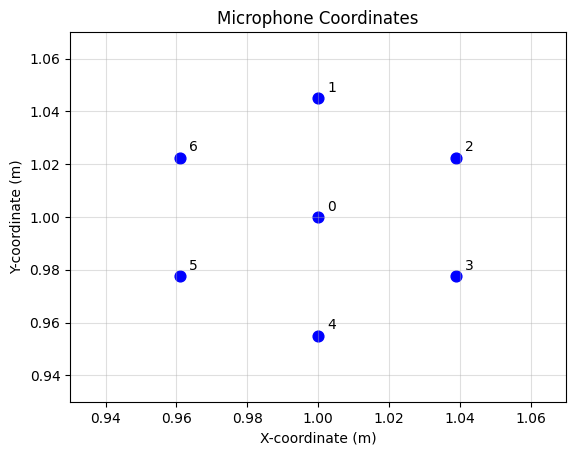

In [ ]:
# Plot the mic coordinates with a 2-D scatter plot along with labels
for i, x in enumerate(myMicArrayCoordinates.T):
  plt.scatter(x[0], x[1], 60, color='blue')
  plt.annotate(i, (x[0] + 0.0025, x[1] + 0.0025))

plt.xlabel('X-coordinate (m)')
plt.ylabel('Y-coordinate (m)')
plt.title('Microphone Coordinates')
plt.grid(alpha = 0.4)
eps = 0.07
plt.xlim(1 - eps, 1 + eps)
plt.ylim(1 - eps, 1 + eps)
plt.show()

# 2-D Version

In [ ]:
# Create a shoebox room

# Room Config 1
# room_w = 2 # metres
# room_l = 3 # metres
# room_h = 2 # metres

# Room Config 2
SCALING_FACTOR = 39.37
room_w = 5 * 12 # inches
room_l = 7 * 12 # inches
room_h = 2 # metres (actually 8 inches)
room_w = room_w / SCALING_FACTOR # metres
room_l = room_l / SCALING_FACTOR # metres

# print(room_w, room_l)

sigma2_n = 5e-7

# 3D
# room = pra.ShoeBox([room_w, room_l, room_h], fs=FS, max_order=0, sigma2_awgn=sigma2_n)

# 2D
room = pra.ShoeBox([room_w, room_l], fs=FS, max_order=0, sigma2_awgn=sigma2_n)

In [ ]:
[room_w, room_l]

[1.5240030480060962, 2.1336042672085345]

In [ ]:
# Filter parameters
Lg_t = 0.100  # Filter size in seconds
Lg = np.ceil(Lg_t * FS)  # Filter size in samples, ensure an integer

In [ ]:
# Add the sound sources
signal1 = pra.highpass(pra.normalize(audioStreams['Conv1_mono.wav']), FS)
signal2 = pra.highpass(pra.normalize(audioStreams['Conv2_mono.wav']), FS)

# 3D
# room.add_source(position=[0.5, room_l - 0.5, room_h/2], signal=signal1)
# room.add_source(position=[room_w - 0.5, room_l - 0.5, room_h/2], signal=signal2)

# 2D
room.add_source(position=[(12 + 5)/SCALING_FACTOR, room_l - 5/SCALING_FACTOR], signal=signal1)
room.add_source(position=[room_w - (12 + 5)/SCALING_FACTOR, room_l - 5/SCALING_FACTOR], signal=signal2)

In [ ]:
# Add microphone array

# 3D
# myMicArrayCoordinates = generateMicCoordinatesUMA([room_w/2, room_l/2, room_h/2], includeThirdDimension=True)

# 2D
myMicArrayCoordinates = generateMicCoordinatesUMA([room_w/2, room_l - (28 - 4)/SCALING_FACTOR], includeThirdDimension=False)

# myMicArrayObject = pra.MicrophoneArray(myMicArrayCoordinates, room.fs)
myMicArrayObject = pra.Beamformer(myMicArrayCoordinates, room.fs, Lg = Lg)
room.add_microphone_array(myMicArrayObject)

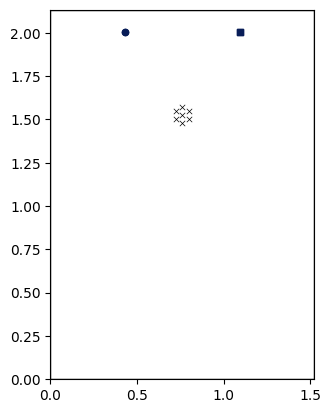

In [ ]:
# fig = plt.figure(figsize=(10, 10))

# 3D
# fig, ax = room.plot(aspect = 'equal', mic_marker_size=3)

# 2D
fig, ax = room.plot(mic_marker_size=15)

In [ ]:
# Run simulation
room.simulate()

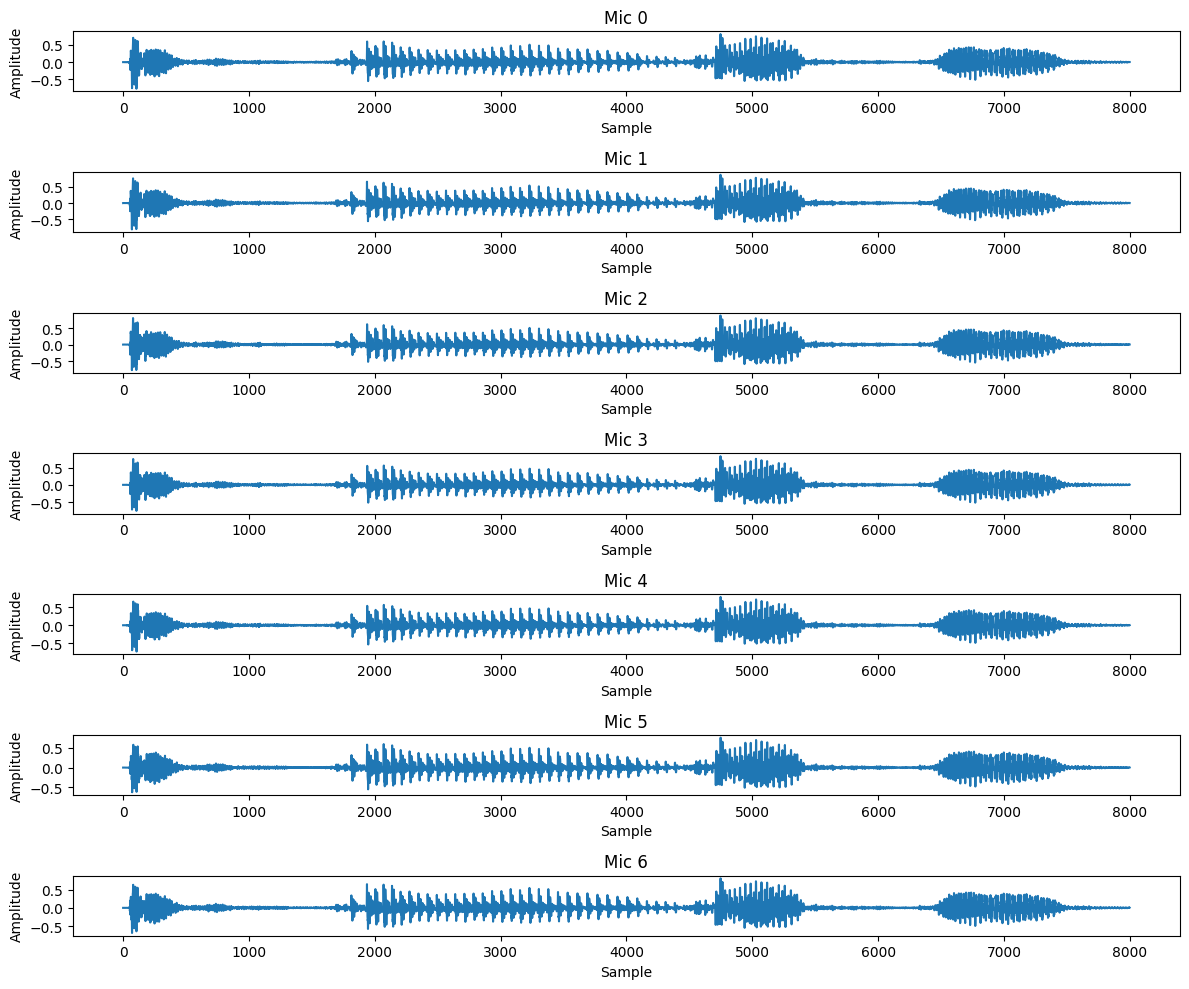

In [ ]:
# Plot the first 5 of the received mic signals in 7 different subplots
fig, axs = plt.subplots(7, 1, figsize=(12, 10))
for i in range(7):
  axs[i].plot(room.mic_array.signals[i][:int(FS*1)])
  axs[i].set_title('Mic {}'.format(i))
  axs[i].set_xlabel('Sample')
  axs[i].set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
# Listen to the a recorded signal
Audio(room.mic_array.signals[0], rate=room.fs)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Save a signle channel for demos
sf.write(projDir + "simulated_recordings/demo_mix.wav", room.mic_array.signals[0], room.fs, subtype='PCM_16')

In [ ]:
# Save the simulated sound to a folder
# os.mkdir(projDir + "simulated_recordings")
room.mic_array.to_wav(projDir + "simulated_recordings/simulated_recording_3.wav", norm=True, bitdepth=np.int16)

# Compute beamforming filters

In [ ]:
# Compute beamforming filters
myMicArrayObject.rake_mvdr_filters(source = room.sources[0], interferer=room.sources[1], R_n=sigma2_n * np.eye(int(Lg) * myMicArrayObject.M))

22195.092026427024

In [ ]:
# Process the signal
output = myMicArrayObject.process()
output = pra.normalize(pra.highpass(output, FS))

In [ ]:
Audio(output, rate=FS)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Test on real_recordings

# Load the recording
y_rec, sr = librosa.load(projDir + "real_recordings/FullTest.wav", sr=None, mono=False)
y_rec = y_rec[0:7, :]
print(y_rec.shape)

# Resample to FS
y_rec = librosa.resample(y_rec, orig_sr=sr, target_sr=FS)
print(y_rec.shape)

(7, 177264544)
(7, 29544091)


In [ ]:
def multiChannelNormalize(signal, bits=None):
    s = signal.copy()

    # normalize per channel (axis=0 is samples, axis=1 is channels)
    s /= np.abs(s).max(axis=0, keepdims=True)

    if bits is not None:
        s *= 2 ** (bits - 1) - 1
        s = np.clip(s, -(2 ** (bits - 1)), 2 ** (bits - 1) - 1)

    return s

In [ ]:
# Process the audio recording

y_rec_processed = y_rec.copy()

for i in range(y_rec_processed.shape[0]):
  y_rec_processed[i] = pra.highpass(y_rec_processed[i], FS)

# y_rec_processed = multiChannelNormalize(y_rec_processed)

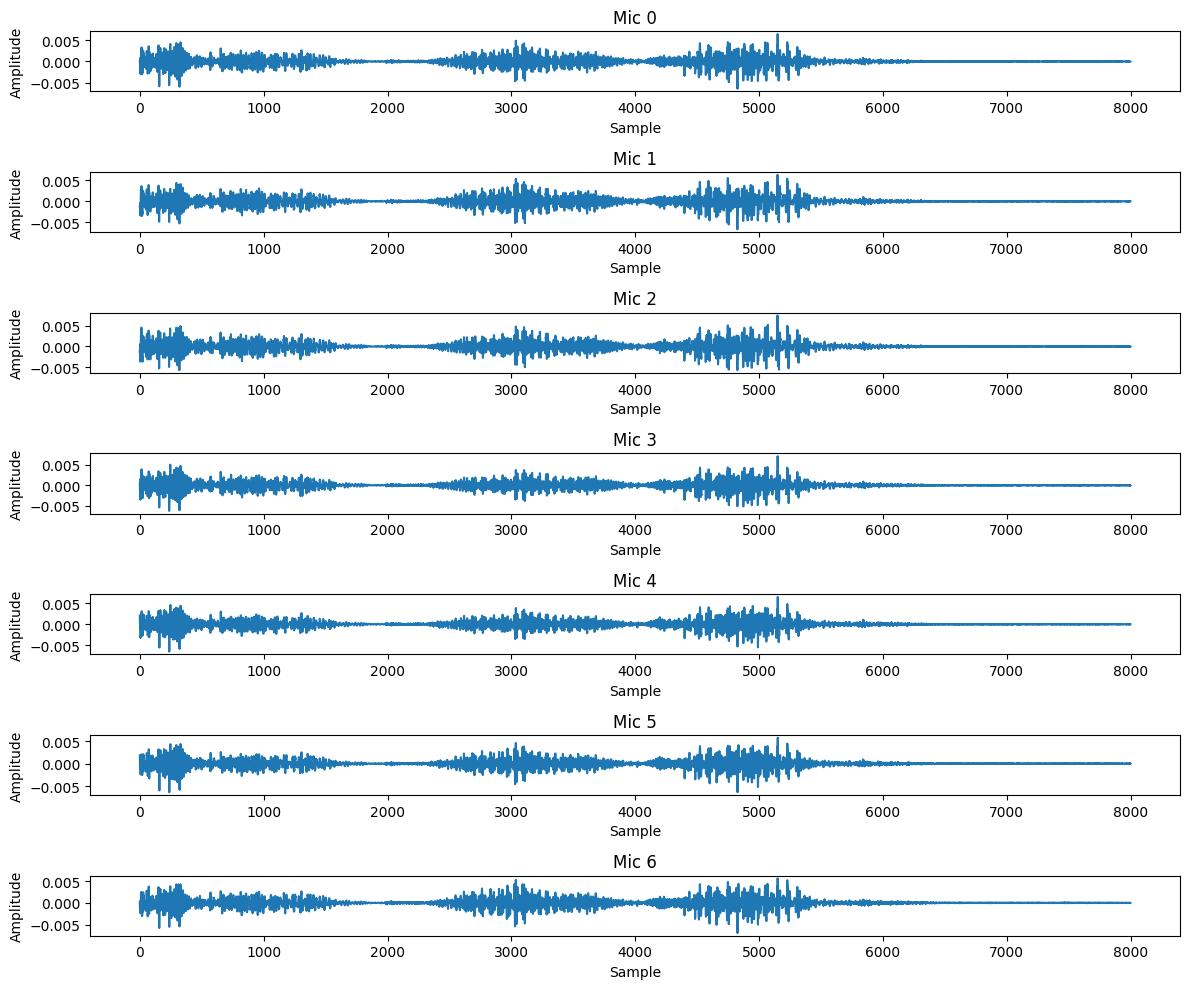

In [ ]:
# View 1 s
fig, axs = plt.subplots(7, 1, figsize=(12, 10))
for i in range(7):
  axs[i].plot(y_rec_processed[i][int(FS*180):int(FS*181)])
  axs[i].set_title('Mic {}'.format(i))
  axs[i].set_xlabel('Sample')
  axs[i].set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
# Apply beamforming
myMicArrayObject.signals = y_rec_processed
output = myMicArrayObject.process()
output = pra.normalize(pra.highpass(output, FS))

In [ ]:
# Listen to first channel
Audio(y_rec_processed[0], rate=FS)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Listen to the audio
Audio(output, rate=FS)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Save the output
sf.write(projDir + "FullTest_Sep_Conv2.wav", output, room.fs, subtype='PCM_16')

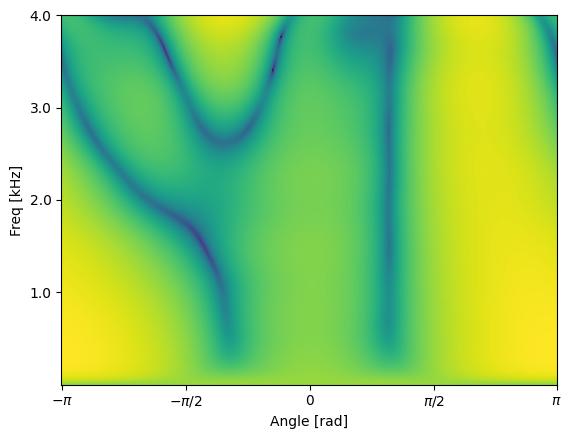

In [ ]:
fig = myMicArrayObject.plot_beam_response()

(-0.25, 3.25)

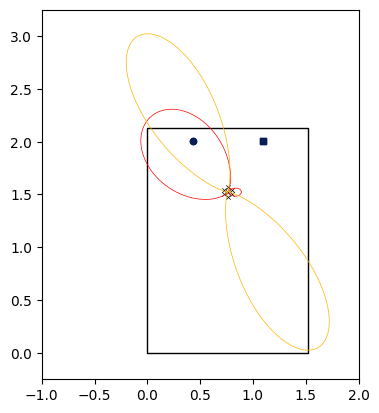

In [ ]:
fig, ax = room.plot(freq=[2000, 4000])
ax.set_xlim(-1, 2)
ax.set_ylim(-0.25, 3.25)
# ax.legend([500, 1000, 2000, 4000])

In [ ]:
sf.write(projDir + "simulated_recordings/demo_conv1_beamform_output.wav", output, room.fs, subtype='PCM_16')

In [ ]:
myMicArrayObject.rake_mvdr_filters(source = room.sources[1], interferer=room.sources[0], R_n=sigma2_n * np.eye(int(Lg) * myMicArrayObject.M))

np.float64(22195.091475470315)

In [ ]:
output = myMicArrayObject.process()
output = pra.normalize(pra.highpass(output, FS))

In [ ]:
Audio(output, rate=FS)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sf.write(projDir + "simulated_recordings/demo_conv2_beamform_output.wav", output, room.fs, subtype='PCM_16')

(-1.0, 4.0)

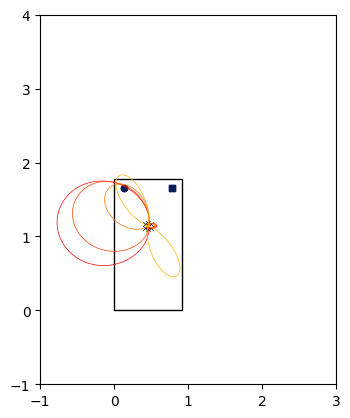

In [ ]:
fig, ax = room.plot(freq=[500, 1000, 2000, 4000])
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 4)
# ax.legend([500, 1000, 2000, 4000])

The direct SNR for good source is 13.68283991205441


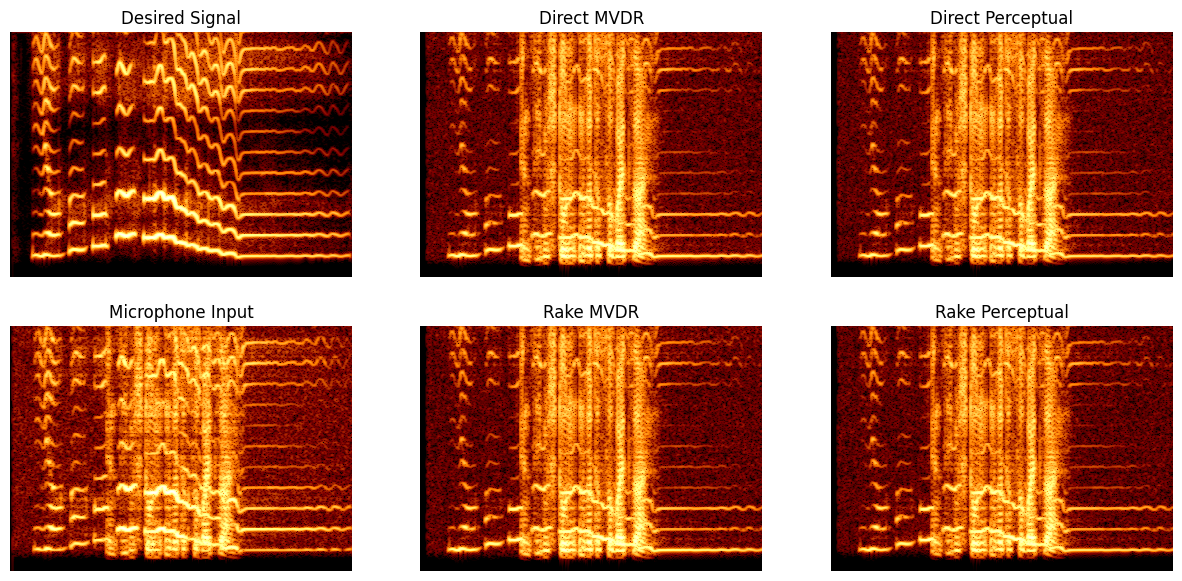

In [ ]:
"""
Plot all the spectrogram
"""

dSNR = pra.dB(room1.direct_snr(mics.center[:, 0], source=0), power=True)
print("The direct SNR for good source is " + str(dSNR))

# remove a bit of signal at the end
n_lim = int(np.ceil(len(input_mic) - t_cut * Fs))
input_clean = signal1[:n_lim]
input_mic = input_mic[:n_lim]
out_DirectMVDR = out_DirectMVDR[:n_lim]
out_RakeMVDR = out_RakeMVDR[:n_lim]
out_DirectPerceptual = out_DirectPerceptual[:n_lim]
out_RakePerceptual = out_RakePerceptual[:n_lim]


# compute time-frequency planes
F0 = stft.analysis(input_clean, fft_size, fft_hop, win=analysis_window, zp_back=fft_zp)
F1 = stft.analysis(input_mic, fft_size, fft_hop, win=analysis_window, zp_back=fft_zp)
F2 = stft.analysis(
    out_DirectMVDR, fft_size, fft_hop, win=analysis_window, zp_back=fft_zp
)
F3 = stft.analysis(out_RakeMVDR, fft_size, fft_hop, win=analysis_window, zp_back=fft_zp)
F4 = stft.analysis(
    out_DirectPerceptual, fft_size, fft_hop, win=analysis_window, zp_back=fft_zp
)
F5 = stft.analysis(
    out_RakePerceptual, fft_size, fft_hop, win=analysis_window, zp_back=fft_zp
)

# (not so) fancy way to set the scale to avoid having the spectrum
# dominated by a few outliers
p_min = 7
p_max = 100
all_vals = np.concatenate(
    (
        pra.dB(F1 + pra.eps),
        pra.dB(F2 + pra.eps),
        pra.dB(F3 + pra.eps),
        pra.dB(F0 + pra.eps),
        pra.dB(F4 + pra.eps),
        pra.dB(F5 + pra.eps),
    )
).flatten()
vmin, vmax = np.percentile(all_vals, [p_min, p_max])

cmap = "afmhot"
interpolation = "none"

fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=3)


def plot_spectrogram(F, title):
    plt.imshow(
        pra.dB(F.T),
        extent=[0, 1, 0, Fs / 2],
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        cmap=plt.get_cmap(cmap),
        interpolation=interpolation,
    )
    ax.set_title(title)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_aspect("auto")
    ax.axis("off")


ax = plt.subplot(2, 3, 1)
plot_spectrogram(F0, "Desired Signal")

ax = plt.subplot(2, 3, 4)
plot_spectrogram(F1, "Microphone Input")

ax = plt.subplot(2, 3, 2)
plot_spectrogram(F2, "Direct MVDR")

ax = plt.subplot(2, 3, 5)
plot_spectrogram(F3, "Rake MVDR")

ax = plt.subplot(2, 3, 3)
plot_spectrogram(F4, "Direct Perceptual")

ax = plt.subplot(2, 3, 6)
plot_spectrogram(F5, "Rake Perceptual")

fig.savefig(path + "/figures/spectrograms.png", dpi=150)

plt.show()

# Plot the room model (ignoring reflections)

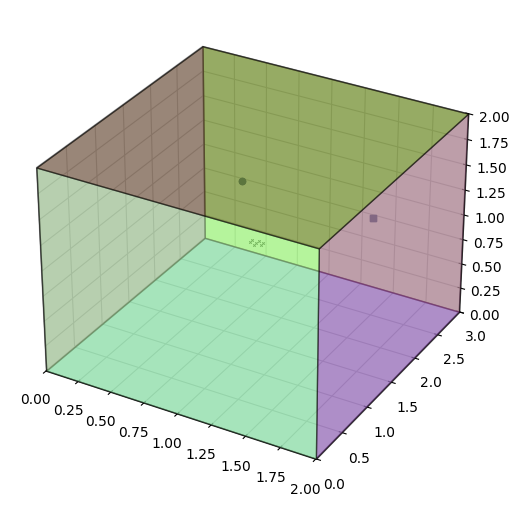

In [ ]:
# fig = plt.figure(figsize=(10, 10))
fig, ax = room.plot(aspect = 'equal', mic_marker_size=3)